In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    print(dirname)

/kaggle/input
/kaggle/input/brain-tumor-mri-scans
/kaggle/input/brain-tumor-mri-scans/pituitary
/kaggle/input/brain-tumor-mri-scans/healthy
/kaggle/input/brain-tumor-mri-scans/meningioma
/kaggle/input/brain-tumor-mri-scans/glioma


## Loading data from directory

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

directory="/kaggle/input/brain-tumor-mri-scans"
clas_names=['pituitary','healthy','meningioma','glioma']

dataset= image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    class_names=clas_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 7023 files belonging to 4 classes.


In [3]:
image,label=next(iter(dataset.take(1)))
print(image.shape)
print(label.shape)
print(len(dataset))

(256, 256, 3)
(4,)
7023


In [4]:
dataset_size=len(dataset)

val_size=int(0.1*dataset_size)


train_set=dataset.take(int(0.8*dataset_size))
remaining_set=dataset.skip(int(0.8*dataset_size))
val_set=remaining_set.take(val_size)
test_set=remaining_set.skip(val_size)

In [5]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

5618
702
703


## preprocessing steps

In [6]:
def resize_rescale (image,label):
    
    image=tf.image.resize(image,[255,255])
    image=image/255.0
    
    return(image,label)

In [7]:
train_set=train_set.batch(batch_size=32).shuffle(buffer_size=200,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE).map(resize_rescale,num_parallel_calls=tf.data.AUTOTUNE)
val_set=val_set.batch(batch_size=32).shuffle(buffer_size=200,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE).map(resize_rescale,num_parallel_calls=tf.data.AUTOTUNE)
test_set=test_set.batch(batch_size=32).shuffle(buffer_size=200,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE).map(resize_rescale,num_parallel_calls=tf.data.AUTOTUNE)

## Creating Sequential CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,BatchNormalization,Dropout,Dense 
from tensorflow.keras.regularizers import L2,L1
model=tf.keras.Sequential([
    
    InputLayer(input_shape=(256,256,3)),
    
    Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_regularizer=L2(0.0)),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = 0.1 ),
    
    Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu',kernel_regularizer=L2(0.0)),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    
    Flatten(),
    
    Dense( 100, activation = "relu", kernel_regularizer = L2(0.0)),
    BatchNormalization(),
    Dropout(rate = 0.1),

    Dense( 10, activation = "relu", kernel_regularizer = L2(0.0)),
    BatchNormalization(),

    Dense(4, activation = "softmax"),
    
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,130 (23.47 MB)

 Trainable params: 6,152,866 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

loss_function= CategoricalCrossentropy()
metrics= [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [10]:
model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss=loss_function,
metrics=metrics
)

# Training Model with Train and Validation datasets

In [11]:
history=model.fit(
train_set,
validation_data=val_set,
epochs=15,
verbose=1)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 187s 970ms/step - accuracy: 0.6893 - loss: 0.8672 - top_k_accuracy: 0.8632 - val_accuracy: 0.3105 - val_loss: 2.7970 - val_top_k_accuracy: 0.6481
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 171s 937ms/step - accuracy: 0.8972 - loss: 0.3213 - top_k_accuracy: 0.9854 - val_accuracy: 0.4259 - val_loss: 2.2343 - val_top_k_accuracy: 0.8148
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 174s 948ms/step - accuracy: 0.9545 - loss: 0.1685 - top_k_accuracy: 0.9960 - val_accuracy: 0.7037 - val_loss: 3.9003 - val_top_k_accuracy: 0.8946
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 201s 940ms/step - accuracy: 0.9585 - loss: 0.1362 - top_k_accuracy: 0.9962 - val_accuracy: 0.8917 - val_loss: 1.5091 - val_top_k_accuracy: 0.9786
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 174s 954ms/step - accuracy: 0.9840 - loss: 0.0756 - top_k_accuracy: 0.9997 - val_accuracy: 0.9573 - val_loss: 0.4244 - val_top_k_accuracy: 0.9957
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 205s 965ms/step - accuracy: 0.

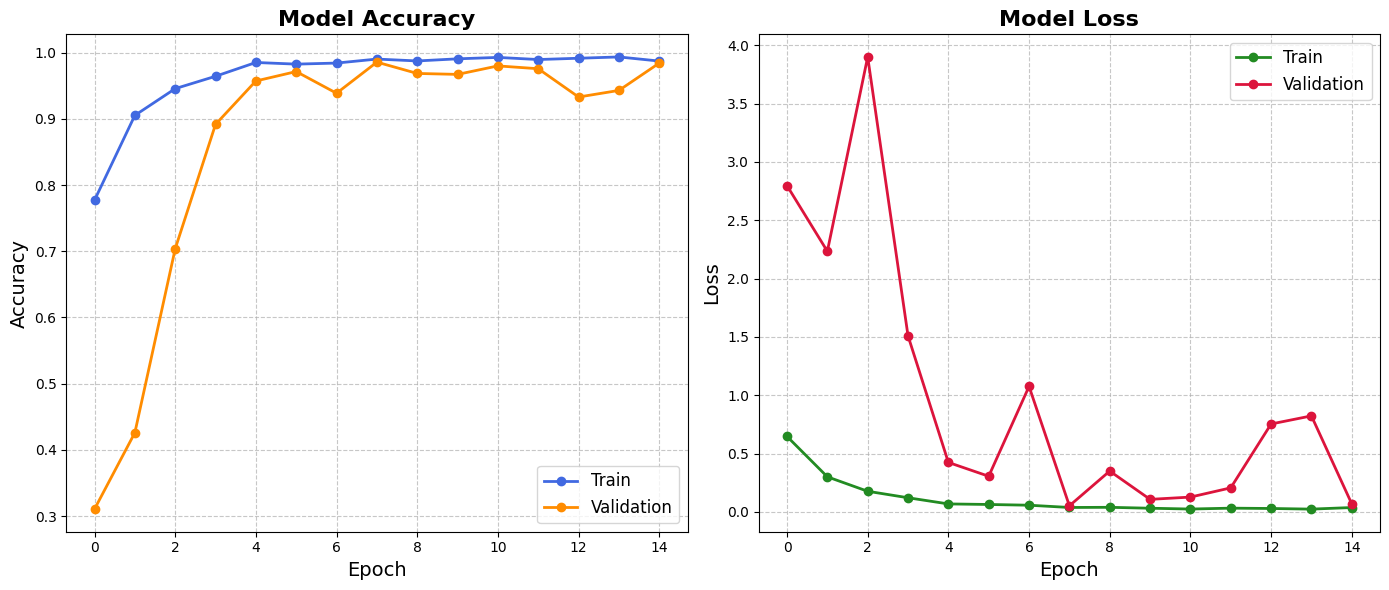

Training history plotted.


In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='royalblue', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], color='darkorange', linewidth=2, marker='o')
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='forestgreen', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], color='crimson', linewidth=2, marker='o')
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(['Train', 'Validation'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


print("Training history plotted.")

In [13]:
test_loss, test_accuracy, test_top_k_accuracy = model.evaluate(test_set)

# Sonuçları ekrana yazdırma
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Top K Accuracy: {test_top_k_accuracy}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.9837 - loss: 0.0785 - top_k_accuracy: 0.9968
Test Loss: 0.08593807369470596
Test Accuracy: 0.9800853729248047
Top K Accuracy: 0.9971550703048706
